In [ ]:
import os
import time
from datetime import datetime, timedelta
from os import path

import contextily as cx
import geopandas as gpd
import meteostat
import pandas as pd
import tqdm
import xarray as xr
import xvec  # noqa: F401
from meteostations.clients import agrometeo

import tstore

METEOSTAT_CRS = "epsg:4326"
METEOSTAT_VAR_DICT = {
    "temp": "temperature",
    "rhum": "water_vapour",
    "prcp": "precipitation",
}


def get_tstore_filepaths(base_dir):
    return [
        path.join(dp, f) for dp, dn, filenames in os.walk(base_dir) for f in filenames
    ]

Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.



In [ ]:
variables = ["temperature", "water_vapour", "precipitation"]
num_years = 5

## Get stations
### Global Hourly - Integrated Surface Database (ISD)
We will use the [meteostat](https://github.com/meteostat/meteostat-python) package to get the data from the ISD.

In [ ]:
isd_stations = meteostat.Stations().region("CH", "VD")
isd_stations_df = isd_stations.fetch(isd_stations.count())
isd_stations_df

,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,hourly_end,daily_start,daily_end,monthly_start,monthly_end
id,,,,,,,,,,,,,,,
06610,Payerne,CH,VD,06610,LSMP,46.8167,6.9500,490.0,Europe/Zurich,2015-09-03,2024-09-04,1964-08-01,2024-08-16,1964-01-01,2022-01-01
06619,Fretaz La / Vugelles,CH,VD,06619,<NA>,46.8406,6.5764,1205.0,Europe/Zurich,NaT,NaT,NaT,NaT,NaT,NaT
06702,La Dole,CH,VD,06702,<NA>,46.4333,6.1000,1670.0,Europe/Zurich,NaT,NaT,NaT,NaT,NaT,NaT
06705,Nyon / Changins,CH,VD,06705,<NA>,46.4011,6.2278,455.0,Europe/Zurich,NaT,NaT,NaT,NaT,1949-01-01,1977-01-01
06710,Lausanne,CH,VD,06710,LSGL,46.5500,6.6167,616.0,Europe/Zurich,NaT,NaT,NaT,NaT,NaT,NaT
06711,Pully,CH,VD,06711,<NA>,46.5122,6.6675,456.0,Europe/Zurich,NaT,NaT,NaT,NaT,NaT,NaT
06712,Aigle,CH,VD,06712,<NA>,46.3333,6.9167,381.0,Europe/Zurich,NaT,NaT,NaT,NaT,NaT,NaT
06717,Grand St. Bernard / Grand Saint Bernard,CH,VD,06717,<NA>,45.8689,7.1708,2472.0,Europe/Zurich,NaT,NaT,1864-01-01,2024-08-18,1864-01-01,2022-01-01


### Agrometeo

In [ ]:
client = agrometeo.AgrometeoClient("Canton de Vaud")
client.stations_gdf

### Combine into single geo-data frame

In [ ]:
stations_gdf = (
    pd.concat(
        [
            gpd.GeoSeries(
                gpd.points_from_xy(
                    isd_stations_df["longitude"],
                    isd_stations_df["latitude"],
                    crs=METEOSTAT_CRS,
                ),
                name="geometry",
                index=isd_stations_df.index,
            ).to_crs(client.stations_gdf.crs),
            client.stations_gdf["geometry"],
        ],
        axis="rows",
    )
    .rename_axis(index="station")
    .reset_index()
)
# TODO: https://github.com/wesm/feather/issues/349
stations_gdf["station"] = stations_gdf["station"].astype(str)

,station,geometry
0,06610,POINT (562709.335 185177.384)
1,06619,POINT (534227.820 188080.120)
2,06702,POINT (497116.859 143319.101)
3,06705,POINT (506882.953 139580.197)
4,06710,POINT (536962.781 155743.719)
5,06711,POINT (540817.288 151502.237)
6,06712,POINT (559809.660 131457.276)
7,06717,POINT (579198.599 79732.982)
8,1,POINT (521720.000 148080.000)
9,3,POINT (507130.000 139310.000)


## Get time series of observations

In [ ]:
end = datetime(year=2023, month=12, day=31)
# https://pandas.pydata.org/docs/user_guide/timeseries.html#period-aliases
freq = "1MS"

# date range to chunk agrometeo requests
date_range = pd.date_range(
    end - timedelta(days=365 * num_years),
    end + timedelta(days=31),
    freq=freq,
)

(Timestamp('2019-01-01 00:00:00'), Timestamp('2024-01-01 00:00:00'))

### Global Hourly - Integrated Surface Database (ISD)

In [ ]:
isd_ts_df = meteostat.Hourly(
    isd_stations_df,
    start=date_range[0],
    end=date_range[-1] - timedelta(hours=1),
).fetch()
isd_ts_df

temp  dwpt  rhum  prcp  snow  wdir  wspd  wpgt  \
station time                                                                  
06610   2019-01-01 00:00:00   5.0   3.7  91.0   0.0   NaN  36.0   4.0   9.3   
        2019-01-01 01:00:00   4.9   3.6  91.0   0.0   NaN  55.0   4.0  11.0   
        2019-01-01 02:00:00   4.9   3.2  89.0   0.0   NaN  49.0   8.0  15.0   
        2019-01-01 03:00:00   4.6   3.4  92.0   0.0   NaN  63.0   5.0   7.4   
        2019-01-01 04:00:00   4.4   3.1  91.0   0.0   NaN  67.0   3.0  13.0   
...                           ...   ...   ...   ...   ...   ...   ...   ...   
06717   2023-12-31 19:00:00  -6.5  -7.0  96.0   1.5   NaN  85.0  20.4  35.2   
        2023-12-31 20:00:00  -6.7  -7.1  97.0   0.7   NaN  87.0  18.5  35.2   
        2023-12-31 21:00:00  -6.9  -8.1  91.0   0.1   NaN  87.0  18.5  33.3   
        2023-12-31 22:00:00  -7.5  -9.3  87.0   0.3   NaN  89.0  11.1  18.5   
        2023-12-31 23:00:00  -7.8  -9.7  86.0   0.3   NaN  87.0   9.3  20.4   

                               pres  tsun  coco  
station time                                     
06610   2019-01-01 00:00:00  1034.3   NaN   5.0  
        2019-01-01 01:00:00  1034.5   NaN   5.0  
        2019-01-01 02:00:00  1034.8   NaN   3.0  
        2019-01-01 03:00:00  1034.4   NaN   3.0  
        2019-01-01 04:00:00  1033.5   NaN   3.0  
...                             ...   ...   ...  
06717   2023-12-31 19:00:00     NaN   NaN  15.0  
        2023-12-31 20:00:00     NaN   NaN  15.0  
        2023-12-31 21:00:00     NaN   NaN  15.0  
        2023-12-31 22:00:00     NaN   NaN  14.0  
        2023-12-31 23:00:00     NaN   NaN  14.0  

[349014 rows x 11 columns]

### Agrometeo

In [ ]:
agm_ts_df = (
    pd.concat(
        [
            client.get_ts_df(variables, start_date, end_date - timedelta(days=1))
            for start_date, end_date in tqdm.tqdm(
                zip(date_range[:-1], date_range[1:]),
                total=len(date_range) - 1,
            )
        ],
    )
    .stack(level=0, future_stack=True)
    .swaplevel()
    .sort_index()
)
agm_ts_df

100%|████████████████████████████████████████████████| 60/60 [00:59<00:00,  1.01it/s]


variable                     temperature  water_vapour  precipitation
station time                                                         
1       2019-01-01 00:00:00          5.9          89.0            0.0
        2019-01-01 00:10:00          5.7          89.0            0.0
        2019-01-01 00:20:00          5.6          90.0            0.0
        2019-01-01 00:30:00          5.7          89.0            0.0
        2019-01-01 00:40:00          5.7          89.0            0.0
...                                  ...           ...            ...
305     2023-12-31 23:10:00          5.5         100.0            0.0
        2023-12-31 23:20:00          5.5         100.0            0.0
        2023-12-31 23:30:00          5.5         100.0            0.0
        2023-12-31 23:40:00          5.5         100.0            0.0
        2023-12-31 23:50:00          5.5         100.0            0.0

[8677086 rows x 3 columns]

## TStore

In [ ]:
long_ts_df = pd.concat(
    [isd_ts_df.rename(columns=METEOSTAT_VAR_DICT)[variables], agm_ts_df],
    axis="rows",
).reset_index()
# TODO: https://github.com/wesm/feather/issues/349
long_ts_df["station"] = long_ts_df["station"].astype(str)

# tstore arguments
tstore_dir = "vaud-tstore"
id_var = "station"
time_var = "time"
partitioning = "year"
tstore_structure = "id-var"

# init tstore
tslong = tstore.TSLong(
    long_ts_df,
    id_var=id_var,
    time_var=time_var,
    geometry=stations_gdf,
)

# dump
start = time.time()
tslong.to_tstore(
    # TSTORE options
    tstore_dir,
    # TSTORE options
    partitioning=partitioning,
    tstore_structure=tstore_structure,
)
print(f"Dumped tstore in: {time.time() - start:.2f} s")

Dumped tstore in: 4.31 s


In [ ]:
tstore_filepaths = get_tstore_filepaths(tstore_dir)
for line in tstore_filepaths[:5] + ["..."] + tstore_filepaths[-5:]:
    if line.endswith("parquet"):
        print(line, f"({path.getsize(line)/1e6} MB)")
    else:
        print(line)

total_size = sum(path.getsize(tstore_filepath) for tstore_filepath in tstore_filepaths)
print(f"Total size: {total_size/1e6} MB (in {len(tstore_filepaths)} files)")

vaud-tstore/tstore_metadata.yaml
vaud-tstore/_attributes.parquet (0.008278 MB)
vaud-tstore/96/ts_variable/_common_metadata
vaud-tstore/96/ts_variable/_metadata
vaud-tstore/96/ts_variable/year=2020/part-0.parquet (0.590143 MB)
...
vaud-tstore/27/ts_variable/year=2020/part-0.parquet (0.583079 MB)
vaud-tstore/27/ts_variable/year=2021/part-0.parquet (0.579589 MB)
vaud-tstore/27/ts_variable/year=2019/part-0.parquet (0.576437 MB)
vaud-tstore/27/ts_variable/year=2022/part-0.parquet (0.582078 MB)
vaud-tstore/27/ts_variable/year=2023/part-0.parquet (0.585516 MB)
Total size: 100.53394 MB (in 289 files)


In [ ]:
start = time.time()
ts_df = tstore.open_tslong(tstore_dir, backend="pandas")
print(f"Read tstore in: {time.time() - start:.2f} s")

Read tstore in: 3.31 s


In [ ]:
start = time.time()
ts_2021_df = tstore.open_tslong(
    tstore_dir,
    start_time="2021-01-01",
    end_time="2021-01-31",
    inclusive="both",
    backend="pandas",
)
print(f"Read tstore for one year in: {time.time() - start:.2f} s")
ts_2021_df

Read tstore for one year in: 0.20 s


,station,temperature,water_vapour,precipitation
time,,,,
2021-01-01 00:00:00,06702,-3.9,100.0,<NA>
2021-01-01 01:00:00,06702,-4.1,100.0,<NA>
2021-01-01 02:00:00,06702,-4.4,100.0,<NA>
2021-01-01 03:00:00,06702,-4.7,100.0,<NA>
2021-01-01 04:00:00,06702,-5.2,98.0,<NA>
...,...,...,...,...
2021-01-30 23:20:00,27,4.5,100.0,0.0
2021-01-30 23:30:00,27,4.5,100.0,0.0
2021-01-30 23:40:00,27,4.4,100.0,0.0


In [ ]:
tsdf = tstore.open_tsdf(tstore_dir)

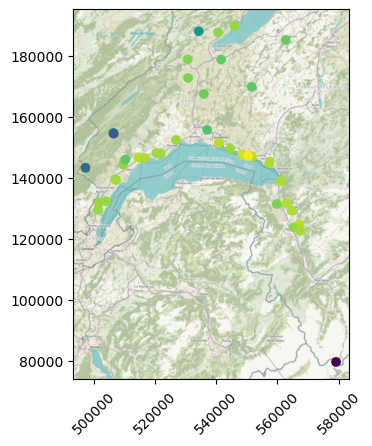

In [ ]:
# example use of tsdf to plot by mean temperature
ax = tsdf.plot(
    tsdf["ts_variable"].apply(lambda ts: ts._obj["temperature"].mean().compute()),
)
cx.add_basemap(ax=ax, crs=stations_gdf.crs, attribution="")
ax.tick_params(axis="x", labelrotation=45)

## xvec

In [ ]:
# agm_ts_df.to_xarray()
ts_ds = long_ts_df.set_index(["station", "time"]).to_xarray()
ts_ds = ts_ds.assign_coords(
    station=stations_gdf.set_index("station").loc[ts_ds.station.values]["geometry"],
)
encoded = ts_ds.xvec.encode_cf()  # ACHTUNG: this requires xvec >= 0.3.0

### netCDF

In [ ]:
nc_filepath = "vaud.nc"

start = time.time()
encoded.to_netcdf(nc_filepath)
print(
    f"Dumped netcdf in: {time.time() - start:.2f} s, {path.getsize(nc_filepath)/1e6} MB",
)
start = time.time()
roundtripped = xr.open_dataset(nc_filepath).xvec.decode_cf()
print(f"Read netcdf in: {time.time() - start:.2f} s")

Dumped netcdf in: 1.04 s, 259.789208 MB
Read netcdf in: 0.05 s


### zarr

In [ ]:
zarr_dir = "vaud.zarr"

start = time.time()
encoded.to_zarr(zarr_dir)
zarr_filepaths = get_tstore_filepaths(zarr_dir)

zarr_size = sum(path.getsize(zarr_filepath) for zarr_filepath in zarr_filepaths)
print(f"Dumped zarr in: {time.time() - start:.2f} s, {zarr_size/1e6} MB")
start = time.time()
roundtripped = xr.open_zarr(zarr_dir).xvec.decode_cf().compute()
print(f"Read zarr in: {time.time() - start:.2f} s")

Dumped zarr in: 0.76 s, 60.486594 MB
Read zarr in: 0.27 s
